# CT5165 Principles of Machine Learning Assignment 3

### Jiarong Li

### ID 20230033, 1MA1

## Introduction

The goal of this assignment is for you to gain practical experience of performing regression on a real world dataset. This is the code part.

## Import libraries

In [14]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder # one hot encoding
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score # for cross validation

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline

## Dataset

Each row describes one individual instance in the dataset. 

The attributes in train.csv are in columns in the following order:

ID, temperature, var1, pressure, windspeed, var2, and electricity_consumption.

The test.csv file is same as train however, the electricity_consumption column is missing.

In this dataset, one or more of the attributes e.g. var2 are categorical and others are continuous. 

The values (A, B, or C) in this attribute do not have a natural ordering. 

It will be necessary to encode the categorical attributes as numeric values using ordinal encoding or one-hot encoding before applying your chosen regression algorithms. 

For a further information on how to encode categorical variables, you may wish to consult the following free online resources:
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

### Data pre-processing

In [15]:
def data_preprocess(data_path, train=True):
    df = pd.read_csv(data_path, 
                     header=0, 
                     parse_dates=['datetime'], infer_datetime_format=True
                    )
    #df_original = train_df
    #one_hot_encoder = OneHotEncoder(sparse=False)
    orinal_encoder = OrdinalEncoder()
    
    df['Year'] = df.datetime.dt.year
    df['Month'] = df.datetime.dt.month
    time = np.array(df.datetime.dt.time).reshape(-1, 1)
    df['Time'] = orinal_encoder.fit_transform(time)
    

    var2 = np.array(df["var2"]).reshape(-1, 1)
    
    var_2_ordinal = orinal_encoder.fit_transform(var2) # transform data
    df["var_2_ordinal"] = var_2_ordinal #.tolist()
    
    if train == True:
        labels = df["electricity_consumption"].to_numpy()
        df = df.drop(columns=["datetime", "ID", "var2", "electricity_consumption"])

    else:
        df = df.drop(columns=["datetime", "ID", "var2"])
        labels = np.array([])
    
    X = df.to_numpy()

    return X, labels

In [16]:
train_data_path = "Electricity-Consumption/train.csv"
test_data_path = "Electricity-Consumption/test.csv"

In [17]:
X_train, y_train = data_preprocess(train_data_path)
print(X_train.shape)
print(y_train.shape)

(26496, 8)
(26496,)


In [9]:
X_test, none = data_preprocess(test_data_path, train=False)
print(none.shape)
print(X_test.shape)

(0,)
(8568, 8)


## Cross validation

### Linear regression

code ref: https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression#0.-Experiments-to-Understand-Overfitting

In [18]:
linear_regression = LinearRegression()

In [22]:
scoring = ["r2", "neg_mean_absolute_error", "neg_mean_squared_error"]
hyper_params = [{'n_features_to_select': list(range(1, 9))}]

# create a KFold object with 5 splits 
kfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)
# for s in scoring:
#     scores = cross_val_score(linear_regression, X_train, y_train, scoring=s, cv=kfolds)
    
#     #view mean absolute error
#     mse = np.mean(np.absolute(scores))  # In general, the lower the MAE, the more closely a model is able to predict the actual observations.
    
#     #view RMSE 
#     rmse = np.sqrt(np.mean(np.absolute(scores)))  # The lower the RMSE, the more closely a model is able to predict the actual observations.
    
#     print(f"scoring = {s}:\nscore = {scores}\nmse = {mse}\nrmse = {rmse}\n\n")


In [24]:
for train, validation in kfolds.split(X_train):
    print(len(X_train[train]), len(X_train[validation]))

21196 5300
21197 5299
21197 5299
21197 5299
21197 5299


#### Hyperparameter Tuning Using Grid Search Cross-Validation

A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called grid search cross-validation.

In [32]:
# Hyperparameter Tuning Using Grid Search Cross-Validation

# step-3: perform grid search
# 3.1 specify model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
rfe = RFE(linear_regression)             
models = []
# 3.2 call GridSearchCV()
for i in scoring:
    model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= i, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  
    model_cv.fit(X_train, y_train)    
    models.append(model_cv)

print(models)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2', verbose=1), GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1), GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='n

In [37]:
for i in models:
    print(i.best_score_)

0.2281414279640158
-68.43979423077523
-9006.293592502212


In [30]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# model_cv.cv_results_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018597,0.004717,0.000215,0.000038,1,{'n_features_to_select': 1},-12149.840400,-11255.797798,-11235.364203,-11600.974976,...,-11508.976578,346.582935,7,-11347.419595,-11570.693541,-11575.672372,-11484.451162,-11558.880183,-11507.423371,86.530659
1,0.019214,0.003623,0.003702,0.002683,2,{'n_features_to_select': 2},-12149.808374,-11257.354111,-11236.171415,-11601.657581,...,-11509.578622,346.253305,8,-11347.413167,-11570.566285,-11575.536610,-11484.332422,-11558.865807,-11507.342858,86.497618
2,0.019402,0.004397,0.003245,0.001571,3,{'n_features_to_select': 3},-10167.451391,-9344.246441,-9406.118657,-9732.900472,...,-9636.724824,296.789946,6,-9500.521848,-9706.412059,-9690.465419,-9609.080028,-9658.890565,-9633.073984,74.141115
3,0.019804,0.002434,0.001411,0.000748,4,{'n_features_to_select': 4},-9987.900914,-9146.871287,-9162.090597,-9469.615626,...,-9413.287895,309.927024,5,-9265.151563,-9475.439009,-9471.083756,-9394.831424,-9436.719269,-9408.645004,77.368448
4,0.015569,0.005919,0.001391,0.001138,5,{'n_features_to_select': 5},-9983.804446,-9151.397215,-9158.127931,-9472.116665,...,-9383.377197,324.571874,4,-9261.577777,-9469.936300,-9467.464926,-9389.739712,-9296.863176,-9377.116378,85.705882
5,0.013419,0.004468,0.002298,0.000879,6,{'n_features_to_select': 6},-9833.226234,-8975.950562,-9032.342954,-9366.113117,...,-9218.009311,348.171066,3,-9120.968242,-9335.589188,-9320.698109,-9238.288329,-9030.908838,-9209.290541,117.324104
6,0.009293,0.003886,0.002499,0.001116,7,{'n_features_to_select': 7},-9549.617569,-8710.282861,-8767.505321,-9123.047173,...,-9006.293593,306.323114,1,-8863.664297,-9073.594060,-9058.706371,-8970.740367,-9030.275528,-8999.396124,76.447182
7,0.006324,0.002985,0.003246,0.001358,8,{'n_features_to_select': 8},-9551.885904,-8712.372473,-8768.055589,-9121.081512,...,-9006.706135,306.564609,2,-8862.147982,-9072.118556,-9057.532446,-8970.651114,-9030.262796,-8998.542579,76.525579


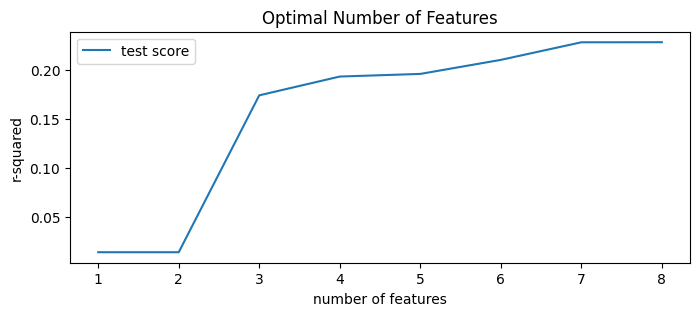

In [250]:
# plotting cv results
plt.figure(figsize=(8,3))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Now we can choose the optimal value of number of features and build a final model.

In [237]:
model_cv.best_estimator_

RFE(estimator=LinearRegression(), n_features_to_select=7)

In [238]:
model_cv.best_score_

0.2281414279640158

In [255]:
model_cv.best_params_

{'n_features_to_select': 7}